# An Ipython notebook version of my LSTM-RNN model
### For more details about this study and citation please refer to the following link on arXiv:
### __[Characterizing the Temporal Dynamics of Information in Visually Guided Predictive Control Using LSTM Recurrent Neural Networks](https://arxiv.org/abs/1805.05946)__
### This notebook contains the basic functions created in Python to perform following actions:
#### - Concatenate training/testing datasets per subject or group of subjects based on their pickle file ID
#### - Create datasets based on integration duration and prediction distance (sliding window method)
#### - Preprocess the training/testing datasets such as normalization and outlier correction
#### - Train the models individually and store each model parameters such as weights, validation loss and history
#### - Test the models using the the test dataset and store the results
#### - plot the statistics of the models performance both in terms of MSE and metric/angular values


<img src="files/CoverPhoto.png">

### Import all modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import csv
import sys
#from sklearn.metrics import mean_squared_error
import math
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import SGD, RMSprop, Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import pandas as pd
from keras.engine.topology import Layer
from matplotlib.pyplot import axis
import formatDataSet
import transformations


Using TensorFlow backend.


Running Main FormatDataSet.py ... 

======> Purpose is to Generate Per Subject Models ... 

Reading the Subject Pickle File ... 
  .\Datasets\2016-5-5-13-7\exp_data-2016-5-5-13-7.pickle
.\Datasets\2016-5-5-13-7\DataSet_All.pickle
.\Datasets\2016-5-5-13-7\trialType_All.pickle


C:\Users\kb4000\My Documents\Python\modellingbyrnn\transformations.py:1911: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


### Remove negative Euler angles and bring them to the range of [0 360]
#### During the process of transforming orientation data from Quaternion to Euler to prevent unnecessary jumps in the data (i.e. from -180 to 180) I perform this correction. This way the model doesn't need to deal with such artifacts 

In [2]:
def correctForNegativeAngles(trainDataSet, testDataSet):

    A = trainDataSet[:,:,5]
    #print('Before = %2.1f %2.1f'% (A.min(), A.max()) )
    A[A<-90] = A[A<-90] + 360
    #print('After = %2.1f %2.1f'% (A.min(), A.max()))
    trainDataSet[:,:,5] = A

    A = testDataSet[:,:,5]
    #print('Before = %2.1f %2.1f'% (A.min(), A.max())) 
    A[A<-90] = A[A<-90] + 360
    #print('After = %2.1f %2.1f'% (A.min(), A.max()))
    testDataSet[:,:,5] = A

    A = trainDataSet[:,:,6]
    #print('Before = %2.1f %2.1f'% (A.min(), A.max()) )
    A[A<-90] = A[A<-90] + 360
    #print('After = %2.1f %2.1f'% (A.min(), A.max()))
    trainDataSet[:,:,6] = A

    A = testDataSet[:,:,6]
    #print('Before = %2.1f %2.1f'% (A.min(), A.max())) 
    A[A<-90] = A[A<-90] + 360
    #print('After = %2.1f %2.1f'% (A.min(), A.max()))
    testDataSet[:,:,6] = A

    A = trainDataSet[:,:,7]
    #print('Before = %2.1f %2.1f %2.1f'% (A.min(), A.max(),A.mean())) 
    A[A<-90] = A[A<-90] + 360
    #print('After = %2.1f %2.1f %2.1f'% (A.min(), A.max(), A.mean()))
    trainDataSet[:,:,7] = A

    A = testDataSet[:,:,7]
    #print('Before = %2.1f %2.1f %2.1f'% (A.min(), A.max(),A.mean())) 
    A[A<-90] = A[A<-90] + 360
    #print('After = %2.1f %2.1f %2.1f'% (A.min(), A.max(), A.mean()))
    testDataSet[:,:,7] = A
    
    return trainDataSet, testDataSet
    

### Reshape the Dataset using a Sliding Window
#### This function reshapes the data based on the batch size, input and output sequence length
#### Parameters: 
> subjectID : individual subject pickle file <br>
> inputLength : number of input sequence time steps <br>
> outPutLength : number of output sequence time steps <br>

#### Returns: 
> trainDataSet : dataset for training (80%) <br>
> trainTrialInfo : training dataset information, such as trial type and trial ID  <br>
> testDataSet : dataset for testing (20%) <br>
> testTrialInfo : testing dataset information, such as trial type and trial ID  <br>

In [3]:
def createWindowedTrainTestDataSets(subjectID, inputLength, outPutLength):

    integrationLength = 45
    PredictionLength = 35
    blankPeriodDuration = 38
    featureDimension = 17
    # Here we are only creating models during blank
    # For all purpose models this should be changed
    seqLength = integrationLength + blankPeriodDuration
    seqLength = inputLength + outPutLength

    trainingSize = 108
    testingSize = 27

    pickleFileName = r'.\Datasets\\'+subjectID+'\\DataSet_All-'+ subjectID +'.pickle'

    print('Reading Data Set File ... \n ', pickleFileName)
    eyeToScreenDistance = 0.0725
    ballDiameter = 0.01
    rawDataSet = pd.read_pickle(pickleFileName)
    #print('Raw Data Set Size = ',len(rawDataSet))

    # Resizing for Train DataSet
    allTrialList = sorted(list(rawDataSet.keys()))
    trainTrialList = allTrialList[0:trainingSize]
    #print(trainTrialList)
    #print('Training Len = ', len(trainTrialList))
    trainDataSet = np.zeros((seqLength, featureDimension))
    trainTrialInfo = np.chararray(1,itemsize = 14)
    for trialNumber in trainTrialList:
        #print('Trial Number =', trialNumber)
        currentTrial = rawDataSet[trialNumber]
        #print('trial ', currentTrial.shape)
        tempVar = currentTrial
        #print('shape1 ', tempVar.shape)
        i = 0
        while(seqLength + i <= tempVar.shape[0]):
            #print(tempVar[0:seqLength,:].shape)
            #print(trainDataSet.shape)
            trainDataSet = np.vstack((trainDataSet, tempVar[0:seqLength,:]))
            trainTrialInfo = np.vstack((trainTrialInfo, trialNumber))
            tempVar = np.roll(tempVar,-1,axis=0)
            i = i + 1

    trainDataSet = trainDataSet[seqLength:,:]
    trainDataSet = trainDataSet.reshape(int(trainDataSet.shape[0]/seqLength), seqLength, trainDataSet.shape[1])
    trainTrialInfo = trainTrialInfo[1:]
    
    #print (rawDataSet[trainTrialList[0]].shape)
    print('Train Data Set Size: ', trainDataSet.shape)
    print('Train TrialInfo Size: ', trainTrialInfo.shape)
    #print(trainDataSet[0:5])
    #print(trainTrialInfo[0:5])

    # Resizing for Test DataSet
    testTrialList = allTrialList[trainingSize:]
    #print(testTrialList)
    #print('Testing Len = ', len(testTrialList))
    testDataSet = np.zeros((seqLength, featureDimension))
    testTrialInfo = np.chararray(1,itemsize = 14)
    for trialNumber in testTrialList:
        #print('Test Number =', trialNumber)
        currentTrial = rawDataSet[trialNumber]
        #print('trial ', currentTrial.shape)
        tempVar = currentTrial
        #print('shape1 ', tempVar.shape)
        i = 0
        while(seqLength + i <= tempVar.shape[0]):
            #print(tempVar[0:seqLength,:].shape)
            #print(testDataSet.shape)
            testDataSet = np.vstack((testDataSet, tempVar[0:seqLength,:]))
            testTrialInfo = np.vstack((testTrialInfo, trialNumber))
            tempVar = np.roll(tempVar,-1,axis=0)
            i = i + 1

    testDataSet = testDataSet[seqLength:,:]
    testDataSet = testDataSet.reshape(int(testDataSet.shape[0]/seqLength), seqLength, testDataSet.shape[1])
    testTrialInfo = testTrialInfo[1:]
    
    #print (rawDataSet[testTrialList[0]].shape)
    print('Test Data Set Size: ', testDataSet.shape)
    print('Test TrialInfo Size: ', testTrialInfo.shape)
    #print(testDataSet[0:5])
    #print(testTrialInfo[0:5])


    return (trainDataSet, trainTrialInfo, testDataSet, testTrialInfo)

### Reshape the Dataset using a Sliding Window
#### This function reshapes the data based on the batch size, input and output sequence length
#### Parameters: 
> subjectID : individual subject pickle file <br>
> inputLength : number of input sequence time steps <br>
> outPutLength : number of output sequence time steps <br>

#### Returns: 
> trainDataSet : dataset for training (80%) <br>
> trainTrialInfo : training dataset information, such as trial type and trial ID  <br>
> testDataSet : dataset for testing (20%) <br>
> testTrialInfo : testing dataset information, such as trial type and trial ID  <br>

In [4]:
def createTrainTestDataSets(subjectID):

    integrationLength = 45
    PredictionLength = 35
    blankPeriodDuration = 38
    featureDimension = 17
    # Here we are only creating models during blank
    # For all purpose models this should be changed
    seqLength = integrationLength + blankPeriodDuration

    trainingSize = 108
    testingSize = 27

    pickleFileName = r'.\Datasets\\'+subjectID+'\\DataSet_All-'+ subjectID +'.pickle'

    print('Reading Data Set File ... \n ', pickleFileName)
    eyeToScreenDistance = 0.0725
    ballDiameter = 0.01
    rawDataSet = pd.read_pickle(pickleFileName)
    #print('Raw Data Set Size = ',len(rawDataSet))

    # Resizing for Train DataSet
    allTrialList = sorted(list(rawDataSet.keys()))
    trainTrialList = allTrialList[0:trainingSize]
    #print(trainTrialList)
    #print('Training Len = ', len(trainTrialList))
    trainDataSet = np.zeros((trainingSize, seqLength, featureDimension))
    trainTrialInfo = np.chararray(trainingSize,itemsize = 14)
    cnt = 0
    for trialNumber in trainTrialList:
        #print('Trial Number =', trialNumber)
        currentTrial = rawDataSet[trialNumber]
        #print('trial ', currentTrial.shape)
        tempVar = currentTrial[0:seqLength, :]
        trainDataSet[cnt, :, :] = tempVar
        trainTrialInfo[cnt] = trialNumber
        cnt = cnt + 1

    #print('cnt = ', cnt)
    #print (rawDataSet[trainTrialList[0]].shape)
    
    #print('Train: ', trainDataSet.shape)
    
    #print(trainTrialInfo.shape)
    #print(trainDataSet[0:5])
    #print(trainTrialInfo[0:5])

    # Resizing for Test DataSet
    testTrialList = allTrialList[trainingSize:]
    #print(testTrialList)
    #print('Testing Len = ', len(testTrialList))
    testDataSet = np.zeros((testingSize, seqLength, featureDimension))
    testTrialInfo = np.chararray(testingSize,itemsize = 14)
    cnt = 0
    for trialNumber in testTrialList:
        #print('Trial Number =', trialNumber)
        currentTrial = rawDataSet[trialNumber]
        tempVar = currentTrial[0:seqLength, :]
        testDataSet[cnt, :, :] = tempVar
        testTrialInfo[cnt] = trialNumber
        cnt = cnt + 1

    #print('cnt = ', cnt)
    #print (rawDataSet[trainTrialList[0]].shape)
    #print('Test: ', testDataSet.shape)
    #print(testTrialInfo.shape)
    #print(testDataSet[0:5])
    #print(testTrialInfo[0:5])

    return (trainDataSet, trainTrialInfo, testDataSet, testTrialInfo)

### Normalize the Dataset 
#### This function normalizes the data 
#### Parameters: 
> dataSet : input dataset <br>

#### Returns: 
> normalDataSet : output dataset <br>

In [5]:
def normalizeDataSet(dataSet):
    size = dataSet.shape
    #print(dataSet.shape)
    rdata = np.reshape(dataSet,(size[0]*size[1],size[2]))
    #print(rdata.shape)

    oldMean = np.mean(rdata, axis=0)
    oldStd = np.std(rdata, axis=0)
    #print('\nmean Before = ', oldMean)
    #print('\nstd Before= ', oldStd)
    # feat_mean = np.array([ -0.56496255,   1.47545376,   0.47065537, -10.3846558,   15.32644376, 38.24852388, -60.86447759,  62.19752817,  52.12331736,   0.70106737])
    # feat_std =  np.array([ 0.25888438,    0.32694775,    0.29356005,    9.35998388,   10.04664913, 60.24531354,   40.3744057,    40.61692218,  135.34311661,    0.45779025])

    normalDataSet = np.zeros(rdata.shape)
    for i in range(len(oldMean)):
        tempVar = rdata[:,i] - oldMean[i]
        normalDataSet[:,i] = np.divide(tempVar,oldStd[i])

    newMean = np.mean(normalDataSet, axis=0)
    newStd = np.std(normalDataSet, axis=0)

    normalDataSet = normalDataSet.reshape(size)
    #print('Final Size = ', normalDataSet.shape)

    #print('\nmean After = ', newMean)
    print('\nstd After= ', newStd)

    '''
    plt.figure(figsize=(12, 10), dpi=200)
    #plt.errorbar(range(len(oldMean)), oldMean, yerr = oldStd, fmt = 'ob', label = 'Before')
    plt.errorbar(range(len(newMean)), newMean, yerr = newStd, fmt = 'or', label = 'After')

    plt.grid(True)
    plt.legend()
    plt.title("Data Normalization Result")
    plt.xlabel('Feature')
    plt.ylabel('Mean')
    #plt.savefig(str(Q)+'SampleTrial'+str(trialNumber)+'.png', dpi=600)
    plt.show()
    '''

    return normalDataSet


### Un-Normalize the Dataset 
#### This function brings the data to the un-normalized value 
#### Parameters: 
> dataSet : input dataset <br>

#### Returns: 
> unNormalDataSet : output dataset <br>

In [6]:
def UnnormalizeDataSet(dataSet, dataSet2):
    size = dataSet.shape
    #print(dataSet.shape)
    rdata = np.reshape(dataSet,(size[0]*size[1],size[2]))
    size2 = dataSet2.shape
    rdata2 = np.reshape(dataSet2,(size2[0]*size2[1],size2[2]))
    #print(rdata.shape)

    oldMean = np.mean(rdata, axis=0)
    oldStd = np.std(rdata, axis=0)
    print('\nmean Before = ', oldMean)
    print('\nstd Before= ', oldStd)
    # feat_mean = np.array([ -0.56496255,   1.47545376,   0.47065537, -10.3846558,   15.32644376, 38.24852388, -60.86447759,  62.19752817,  52.12331736,   0.70106737])
    # feat_std =  np.array([ 0.25888438,    0.32694775,    0.29356005,    9.35998388,   10.04664913, 60.24531354,   40.3744057,    40.61692218,  135.34311661,    0.45779025])

    unNormalDataSet = np.zeros(rdata2.shape)
    for i in range(size2[2]):
        tempVar = np.multiply(rdata2[:,i],oldStd[i])
        unNormalDataSet[:,i] =  tempVar + oldMean[i]

    newMean = np.mean(unNormalDataSet, axis=0)
    newStd = np.std(unNormalDataSet, axis=0)

    unNormalDataSet = unNormalDataSet.reshape(size2)
    #print('Final Size = ', normalDataSet.shape)

    print('\nmean After = ', newMean)
    print('\nstd After= ', newStd)
    
    return unNormalDataSet


### Add temporal decaying to the model
#### To add artifical temporal decay in the data one method is to induce noise to samples proportional to the input length
#### This function is not required in an LSTM model. Since the forget gate is responsible to learn the temporal dependencies


In [7]:
def addDecaying(ntrainDataSetAllSubject, integrationLength):
    print(ntrainDataSetAllSubject.shape)

### Create the RNN model archtecture 
#### This function creates the model object based on the parameters passed to it
#### Parameters: 
> input_seq_length : number of input sequence time steps <br>
> weights_path : the path in which the model weights will be stored <br>
> learningRate : learning rate during training <br>

#### Returns: 
> model : output is the created model object <br>

In [8]:
def createRNN(input_seq_length, weights_path=None, learningRate=0.001):
    """LSTM model that has 3 LSTM layers with 50 units each and one Dense layer on top.
    Model can predict one time step vector with 5 values;
    The model is tuned for optimizer: optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    """
    # input_seq_length = 40
    model = Sequential()
    # layers = [41, 20, 20, 16]
    #layers = [41, 50,  16]
    layers = [17, 25,  8]
    print('Creating RNN with Layer Dimensions of :', layers)
    # first layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1], input_length=input_seq_length,
        return_sequences=False, unroll=True))
    '''
    model.add(Dropout(0.2))
    # second layer
    model.add(LSTM(
           layers[2],
           return_sequences=True, unroll=True))

    model.add(Dropout(0.2))
    # third layer
    model.add(LSTM(
           layers[2],
           return_sequences=False, unroll=True))
    model.add(Dropout(0.2))
    '''
    # Dense layer
    model.add(Dense(
        output_dim=layers[2]))  # Changed from 2
    model.add(Activation("linear"))#Changed from linear to Relu (Kamran)
    # Original Values
    optimizer = Adam(lr=learningRate, beta_1=0.9,
                     beta_2=0.999, epsilon=1e-08, decay=0.0)
    # optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
    # rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(loss="mse", optimizer=optimizer)
    print('model compiled...')
    if weights_path:
        model.load_weights(weights_path)
    return model


### Train the Model 
#### This function trains the model and stores model parameters such as weights and training/validation loss into appropriate paths
#### Parameters: 
> trainDataSet : training DataSet <br>
> model : model object <br>
> epochNumber : number of epochs <br>
> learningRate : learning rate a value between  [0 1] <br>
> integrationLength : input sequence number
> timeStep : an integer value for prediction step number  (i.e. 3 means predicting 3 time steps ahead) <br>

#### Returns: 
> model : output is the trained model object <br>
> history : history object containing the training objects snap shots <br>

In [9]:
def trainModel(trainDataSet, model=None, epochNumber=None, learningRate=None, integrationLength=None, timeStep=None):

    dataSetDimension = trainDataSet.shape
    print(dataSetDimension)

    training_Input = trainDataSet[:, 45 - integrationLength:45, :]
    training_Output = trainDataSet[:, 45 + timeStep, 0:8]
    print("TimeStep = ", str(45 + timeStep), " Selected!")

    # X_train, y_train, X_test, y_test = data
    cb = EarlyStopping(monitor='val_loss', patience=100, verbose=1, mode='min')
    history = model.fit(training_Input, training_Output, batch_size=64,
                        epochs=epochNumber, callbacks=[cb], verbose=2, validation_split=0.15, shuffle=True)
    # fname_weights = './Old_data_varing_in_seq_50_50_50/weights_50_50_50/wieghts_rnn505050_inseq{}'.format(nb_input_seq)
    # fname_weights = r'.\Results\Weights\weights_'+str(dataSetDimension[1] - 35) + '_' + str(timeStep) + '_' + str(learningRate) + '_' + str(epochNumber)
    fname_weights = r'.\Results\Weights\weights_' + \
        str(integrationLength) + '_' + str(timeStep) + \
        '_' + str(learningRate) + '_' + str(epochNumber)
    model.save_weights(fname_weights)
    # fname_Loss = r'.\Results\Weights\Loss_'+str(dataSetDimension[1] - 35)+ '_' + str(timeStep) + '_' + str(learningRate) + '_' + str(epochNumber)
    fname_Loss = r'.\Results\Weights\Loss_' + str(integrationLength) + '_' + str(
        timeStep) + '_' + str(learningRate) + '_' + str(epochNumber)
    pd.to_pickle(history.history['loss'], fname_Loss + r'.pickle')
    # fname_Loss = r'.\Results\Weights\ValidationLoss_'+str(dataSetDimension[1] - 35) + '_' + str(timeStep) + '_' + str(learningRate) + '_' + str(epochNumber)
    fname_Loss = r'.\Results\Weights\ValidationLoss_' + \
        str(integrationLength) + '_' + str(timeStep) + \
        '_' + str(learningRate) + '_' + str(epochNumber)
    pd.to_pickle(history.history['val_loss'], fname_Loss + r'.pickle')

    '''
    predicted = model.predict(X_test)
    predicted = np.array(predicted)

    mse_predict = mean_squared_error(
        predicted, y_test, multioutput='raw_values')

    for item in history.history['loss']:
        f.write('{}\n'.format(item))

    for item in history.history['val_loss']:
        f.write('{}\n'.format(item))


    '''

    return model, history



### Main Training Function (Lets bring everything together!)
#### This is where everything happens: function trains the model and stores model parameters such as weights and training/validation loss into appropriate paths. This can be broken down into following steps:

> 1) Determining the Subject ID list: From all 10 subjects, user can choose which one to include in the dataset. This allows training per subject models <br>

> 2) Specifying the model architecture: Parameters of the model such as integration length, prediction length, etc is specified <br>

> 3) Creating train/test datasets: According to the parameters above the train and test datasets are created <br>

> 4) Normalize/preprocess the train/test datasets: per subject datasets go through a preprocessing step and finally concatenated <br>

> 5) For each prediction distance the models are trained and stored 

In [ ]:
fileTimeList = ['2016-4-19-14-4', '2016-4-22-11-57', '2016-4-27-13-28', '2016-4-28-10-57', '2016-4-29-11-56',
               '2016-5-3-12-52','2016-5-4-13-3', '2016-5-5-13-7', '2016-5-6-11-2', '2016-5-6-13-4']
#fileTimeList = ['2016-4-19-14-4' , '2016-4-27-13-28', '2016-4-28-10-57', '2016-4-29-11-56',
#               '2016-5-3-12-52','2016-5-4-13-3', '2016-5-5-13-7', '2016-5-6-11-2', '2016-5-6-13-4']
fileTimeList = ['2016-5-3-12-52']#['2016-5-6-11-2']#['2016-5-5-13-7']#['2016-5-4-13-3'] #['2016-5-3-12-52']#['2016-4-29-11-56']#['2016-4-28-10-57']# ['2016-4-27-13-28']#['2016-4-22-11-57']#['2016-4-19-14-4']

# These are the tested and verified  values
#timeStepList = [0]#, 5, 10, 15, 20, 25, 30, 35]
#learningRate = [0.0002]#, 0.0002, 0.0002, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001]

timeStepList = [0, 10, 20, 30]
learningRate = [0.0001, 0.0002, 0.0001, 0.0001]

#timeStepList = [30]
#learningRate = [0.0001]

integrationLength = 45
#integrationLength = 30
#integrationLength = 15
#integrationLength = 8
#integrationLength = 4
#integrationLength = 2
PredictionLength = 35
blankPeriodDuration = 38
featureDimension = 17

#trainDataSetAllSubject = np.zeros((1, integrationLength + blankPeriodDuration, featureDimension ))
#testDataSetAllSubject = np.zeros((1, integrationLength + blankPeriodDuration, featureDimension ))

#inputLength = 35
#outPutLength = 20

inputLength = 45
outPutLength = 31

trainDataSetAllSubject = np.zeros((1, inputLength + outPutLength, featureDimension ))
testDataSetAllSubject = np.zeros((1, inputLength + outPutLength, featureDimension ))

print(trainDataSetAllSubject.shape)
trainTrialInfoAll = np.chararray(1,itemsize = 14)
testTrialInfoAll = np.chararray(1,itemsize = 14)
trainTrialInfoAll[0] = 'tr_0_type_t0'
testTrialInfoAll[0] = 'tr_0_type_t0'
for subjectID in fileTimeList:
    #(trainDataSet, trainTrialInfo, testDataSet, testTrialInfo) = createTrainTestDataSets(subjectID)
    (trainDataSet, trainTrialInfo, testDataSet, testTrialInfo) = createWindowedTrainTestDataSets(subjectID, inputLength, outPutLength)
    trainDataSet, testDataSet = correctForNegativeAngles(trainDataSet, testDataSet)
    trainDataSetAllSubject = np.vstack((trainDataSetAllSubject, trainDataSet))
    testDataSetAllSubject = np.vstack((testDataSetAllSubject, testDataSet))
    print(trainTrialInfo.shape)
    print(trainTrialInfoAll.shape)
    trainTrialInfoAll = np.vstack((trainTrialInfoAll, trainTrialInfo))
    testTrialInfoAll = np.vstack((testTrialInfoAll, testTrialInfo))
trainDataSetAllSubject = np.delete(trainDataSetAllSubject, 0,0)
testDataSetAllSubject = np.delete(testDataSetAllSubject, 0,0)
trainTrialInfoAll = np.delete(trainTrialInfoAll, 0)
testTrialInfoAll = np.delete(testTrialInfoAll, 0)

print('train Data Set Shape = ', trainDataSetAllSubject.shape)
print('test Data Set Shape = ', testDataSetAllSubject.shape)
print('train info Shape = ', trainTrialInfoAll.shape)
print('test info Shape = ', testTrialInfoAll.shape)

#pd.to_pickle(trainDataSetAllSubject, r'.\DataSets\DataSet_Training_All.pickle')
#pd.to_pickle(testDataSetAllSubject, r'.\DataSets\DataSet_Testing_All.pickle')
ntrainDataSetAllSubject = normalizeDataSet(trainDataSetAllSubject)
ntestDataSetAllSubject = normalizeDataSet(testDataSetAllSubject)

integrationLength = 45
#addDecaying(ntrainDataSetAllSubject, integrationLength)

i = 0
for timeStep in timeStepList:
    integrationLength = 45
    model = createRNN(integrationLength, None, learningRate[i])
    trainModel(ntrainDataSetAllSubject, model=model, epochNumber=500, learningRate=learningRate[i], integrationLength=integrationLength, timeStep=timeStep)
    i = i + 1

### Test the Model 
#### This function tests the model and stores model outputs into appropriate paths
#### Parameters: 
> testDataSet : testing DataSet <br> 
> model : model object <br>
> integrationLength : input sequence number
> timeStep : an integer value for prediction step number  (i.e. 3 means predicting 3 time steps ahead) <br>

#### Returns: 
> modelOutput : model output <br>
> testing_Output : ground truth values <br>

In [10]:
def testModel(testDataSet, model=None, integrationLength=None, timeStep=None):
        
    #    model, modelOutput, testingOutput = testModel(nTestDataSet, model, epochNumber=epochNumber)
    dataSetDimension = testDataSet.shape
    print(dataSetDimension)

    testing_Input = testDataSet[:, 45 - integrationLength:45, :]
    testing_Output = testDataSet[:, 45 + timeStep, 0:8]
    print("TimeStep = ", str(45 + timeStep), " Selected!")

    print('Running Model Prediction ...')
    modelOutput = model.predict(testing_Input, verbose=1)
    print(modelOutput.shape)
    print(testing_Output.shape)
    #mse = np.mse(testing_Output.T, modelOutput.T)
    mse = np.mean(np.power(testing_Output - modelOutput, 2), axis=0)

    #print(mse)
    #print(min(mse))
    #print(max(mse))
    print('MSE Shape = ',mse.shape)
    print('\n\n ========== ',45 + timeStep, ' ==========')
    print("%2.3f  %2.3f"%(np.mean(mse), np.std(mse)))
    #figureName = r'.\Results\Figures\PerSubjectModel\modelOutput'
    # Un-normalizing the Data

    '''
    predicted = model.predict(X_test)
    predicted = np.array(predicted)
   
    mse_predict = mean_squared_error(predicted, y_test, multioutput='raw_values')
    
    for item in history.history['loss']:
        f.write('{}\n'.format(item))

    for item in history.history['val_loss']:
        f.write('{}\n'.format(item))
    
    
    '''

    return modelOutput, testing_Output


### Main Testing Function (Lets test the trained models!)
#### This is where everything happens: tests the models and stores all model outputs  into appropriate paths. This can be broken down into following steps:

> 1) Determining the Subject ID list: From all 10 subjects, user can choose which one to include in the dataset. This allows testing per subject models <br>

> 2) Specifying the model architecture: Parameters of the model such as integration length, prediction length, etc is specified <br>

> 3) Creating train/test datasets: According to the parameters above the train and test datasets are created <br>

> 4) Normalize/preprocess the train/test datasets: per subject datasets go through a preprocessing step and finally concatenated <br>

> 5) For each integration length and prediction distance the models are loaded, tested and stored accordingly

In [11]:
fileTimeList = ['2016-4-19-14-4', '2016-4-22-11-57', '2016-4-27-13-28', '2016-4-28-10-57', '2016-4-29-11-56',
               '2016-5-3-12-52','2016-5-4-13-3', '2016-5-5-13-7', '2016-5-6-11-2', '2016-5-6-13-4']
fileTimeList = ['2016-4-19-14-4' , '2016-4-27-13-28', '2016-4-28-10-57', '2016-4-29-11-56',
               '2016-5-3-12-52','2016-5-4-13-3', '2016-5-5-13-7', '2016-5-6-11-2', '2016-5-6-13-4']
timeStepList = [0, 5, 10, 15, 20, 25, 30, 35]
learningRate = [0.0002, 0.0002, 0.0002, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001]
integrationLength = 45
#PredictionLength = 35
#PredictionLength = 15
blankPeriodDuration = 38
featureDimension = 17

trainDataSetAllSubject = np.zeros((1, integrationLength + blankPeriodDuration, featureDimension ))
testDataSetAllSubject = np.zeros((1, integrationLength + blankPeriodDuration, featureDimension ))

print(trainDataSetAllSubject.shape)
trainTrialInfoAll = np.chararray(1,itemsize = 14)
testTrialInfoAll = np.chararray(1,itemsize = 14)
trainTrialInfoAll[0] = 'tr_0_type_t0'
testTrialInfoAll[0] = 'tr_0_type_t0'

for subjectID in fileTimeList:
    (trainDataSet, trainTrialInfo, testDataSet, testTrialInfo) = createTrainTestDataSets(subjectID)
    trainDataSet, testDataSet = correctForNegativeAngles(trainDataSet, testDataSet)
    trainDataSetAllSubject = np.vstack((trainDataSetAllSubject, trainDataSet))
    testDataSetAllSubject = np.vstack((testDataSetAllSubject, testDataSet))
    print(trainTrialInfo.shape)
    print(trainTrialInfoAll.shape)
    trainTrialInfoAll = np.hstack((trainTrialInfoAll, trainTrialInfo))
    testTrialInfoAll = np.hstack((testTrialInfoAll, testTrialInfo))
trainDataSetAllSubject = np.delete(trainDataSetAllSubject, 0,0)
testDataSetAllSubject = np.delete(testDataSetAllSubject, 0,0)
trainTrialInfoAll = np.delete(trainTrialInfoAll, 0)
testTrialInfoAll = np.delete(testTrialInfoAll, 0)

print('train Data Set Shape = ', trainDataSetAllSubject.shape)
print('test Data Set Shape = ', testDataSetAllSubject.shape)
print('train info Shape = ', trainTrialInfoAll.shape)
print('test info Shape = ', testTrialInfoAll.shape)
ntrainDataSetAllSubject = normalizeDataSet(trainDataSetAllSubject)
ntestDataSetAllSubject = normalizeDataSet(testDataSetAllSubject)


integrationList = [2]
for integrationLength in integrationList:
    allModelOutputs = np.zeros((len(timeStepList),testDataSetAllSubject.shape[0],8))
    allTestOutputs = np.zeros((len(timeStepList), testDataSetAllSubject.shape[0],8))
    i = 0
    for timeStep in timeStepList:
        weights_path = r'.\Results\Weights\Integration_2_Models\weights_' + str(integrationLength) + '_'+str(timeStep)+'_'+str(learningRate[i])+'_2000'
        print(weights_path)
        model = createRNN(integrationLength, weights_path, learningRate[i])
        modelOutput, testingOutput = testModel(ntestDataSetAllSubject, model, integrationLength=integrationLength, timeStep=timeStep)
        allModelOutputs[i,:,:] = modelOutput
        allTestOutputs[i,:,:] = testingOutput
        i = i + 1
    TestingResult = UnnormalizeDataSet(testDataSetAllSubject, allTestOutputs)
    ModelResult = UnnormalizeDataSet(testDataSetAllSubject, allModelOutputs)
    #pd.to_pickle(ModelResult,  r'.\Results\ModelOutput\17_Feat_8_Output_LSTM_25\modelOutput_' + 
    #             str(integrationLength) + '.pickle')
    
    #pd.to_pickle(TestingResult,  r'.\Results\ModelOutput\17_Feat_8_Output_LSTM_25\testingInput_' + 
    #             str(integrationLength) + '.pickle')        




        
 

(1, 83, 17)
Reading Data Set File ... 
  .\Datasets\\2016-4-19-14-4\DataSet_All-2016-4-19-14-4.pickle
(108,)
(1,)
Reading Data Set File ... 
  .\Datasets\\2016-4-27-13-28\DataSet_All-2016-4-27-13-28.pickle
(108,)
(109,)
Reading Data Set File ... 
  .\Datasets\\2016-4-28-10-57\DataSet_All-2016-4-28-10-57.pickle
(108,)
(217,)
Reading Data Set File ... 
  .\Datasets\\2016-4-29-11-56\DataSet_All-2016-4-29-11-56.pickle
(108,)
(325,)
Reading Data Set File ... 
  .\Datasets\\2016-5-3-12-52\DataSet_All-2016-5-3-12-52.pickle
(108,)
(433,)
Reading Data Set File ... 
  .\Datasets\\2016-5-4-13-3\DataSet_All-2016-5-4-13-3.pickle
(108,)
(541,)
Reading Data Set File ... 
  .\Datasets\\2016-5-5-13-7\DataSet_All-2016-5-5-13-7.pickle
(108,)
(649,)
Reading Data Set File ... 
  .\Datasets\\2016-5-6-11-2\DataSet_All-2016-5-6-11-2.pickle
(108,)
(757,)
Reading Data Set File ... 
  .\Datasets\\2016-5-6-13-4\DataSet_All-2016-5-6-13-4.pickle
(108,)
(865,)
train Data Set Shape =  (972, 83, 17)
test Data Set Shap

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, unroll=True, input_shape=(2, 17), units=25)`
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:33: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=8)`


model compiled...
(243, 83, 17)
TimeStep =  45  Selected!
Running Model Prediction ...
 32/243 [==>...........................] - ETA: 1s(243, 8)
(243, 8)
MSE Shape =  (8,)


 ==========  45  ==========
0.336  0.284
.\Results\Weights\Integration_2_Models\weights_2_5_0.0002_2000
Creating RNN with Layer Dimensions of : [17, 25, 8]
model compiled...
(243, 83, 17)
TimeStep =  50  Selected!
Running Model Prediction ...
 32/243 [==>...........................] - ETA: 0s(243, 8)
(243, 8)
MSE Shape =  (8,)


 ==========  50  ==========
0.266  0.191
.\Results\Weights\Integration_2_Models\weights_2_10_0.0002_2000
Creating RNN with Layer Dimensions of : [17, 25, 8]
model compiled...
(243, 83, 17)
TimeStep =  55  Selected!
Running Model Prediction ...
 32/243 [==>...........................] - ETA: 0s(243, 8)
(243, 8)
MSE Shape =  (8,)


 ==========  55  ==========
0.215  0.079
.\Results\Weights\Integration_2_Models\weights_2_15_0.0002_2000
Creating RNN with Layer Dimensions of : [17, 25, 8]
model

In [ ]:
print(TestingResult.shape)
data = TestingResult[:,:,0]
gazeX = np.std(data, axis = 1)
print(gazeX)

data = TestingResult[:,:,1]
gazeY = np.std(data, axis = 1)
print(gazeY)

data = TestingResult[:,:,2]
handX = np.std(data, axis = 1)
print(handX)

data = TestingResult[:,:,3]
handY = np.std(data, axis = 1)
print(handY)

data = TestingResult[:,:,4]
handZ = np.std(data, axis = 1)
print(handZ)

### Plotting Gaze Prediction Error 

In [12]:
print(TestingResult.shape)
print(ModelResult.shape)

plt.figure(figsize=(12, 10), dpi=200)
idx = 0
dSqaured = np.power(TestingResult[:,:,idx]-ModelResult[:,:,idx],2)
plt.errorbar(np.array(timeStepList)*(1000/75)+13-5, np.sqrt(np.mean(dSqaured,axis=1)), yerr = (np.std(np.sqrt(dSqaured),axis=1)), fmt = '-or', linewidth = 3, label = 'Gaze (AZ)')
idx = 1
dSqaured = np.power(TestingResult[:,:,idx]-ModelResult[:,:,idx],2)
plt.errorbar(np.array(timeStepList)*(1000/75)+13, np.sqrt(np.mean(dSqaured,axis=1)), yerr = (np.std(np.sqrt(dSqaured),axis=1)), fmt = '-ob', linewidth = 3, label = 'Gaze (EL)')
idx = 2
dSqaured = np.power(TestingResult[:,:,idx]-ModelResult[:,:,idx],2)
#plt.errorbar(np.array(timeStepList)*(1000/75)+13, np.sqrt(np.mean(dSqaured,axis=1)), yerr = (np.std(np.sqrt(dSqaured),axis=1)), fmt = '-og', linewidth = 3, label = 'Hand (AZ)')
idx = 3
dSqaured = np.power(TestingResult[:,:,idx]-ModelResult[:,:,idx],2)
#plt.errorbar(np.array(timeStepList)*(1000/75)+13, np.sqrt(np.mean(dSqaured,axis=1)), yerr = (np.std(np.sqrt(dSqaured),axis=1)), fmt = '-oy', linewidth = 3, label = 'Hand (EL)')


plt.grid(True)
plt.legend(loc = 'upper left', fontsize = 16)
#plt.title("Gaze Prediction Error\nIntegration Window = 200 ms", fontsize = 20)
plt.xlabel('Prediction Distance [ms]', fontsize = 25)
plt.ylabel('Root Mean Squared Error [Degree]', fontsize = 25)
plt.ylim(-0.05,10)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
#plt.savefig('_200_PredictionError_Gaze.png', dpi=600)
plt.show()


(8, 243, 8)
(8, 243, 8)


### Plotting Hand Prediction Error 

In [13]:
print(TestingResult.shape)
print(ModelResult.shape)

plt.figure(figsize=(12, 10), dpi=200)

idx = 4
myDepth = TestingResult[:,:,idx]-ModelResult[:,:,idx]
idx = 2
angle = TestingResult[:,:,idx]-ModelResult[:,:,idx]
x = np.multiply(myDepth, np.sin(angle))
dSqaured = np.power(x,2)
plt.errorbar(np.array(timeStepList)*(1000/75)+13-5, np.sqrt(np.mean(dSqaured,axis=1)), yerr = (np.std(np.sqrt(dSqaured),axis=1)), fmt = '-og', linewidth = 3, label = 'Hand (X)')

idx = 4
myDepth = TestingResult[:,:,idx]-ModelResult[:,:,idx]
idx = 3
angle = TestingResult[:,:,idx]-ModelResult[:,:,idx]
y = np.multiply(myDepth, np.sin(angle))
dSqaured = np.power(y,2)
plt.errorbar(np.array(timeStepList)*(1000/75)+13, np.sqrt(np.mean(dSqaured,axis=1)), yerr = (np.std(np.sqrt(dSqaured),axis=1)), fmt = '-oy', linewidth = 3, label = 'Hand (Y)')

dSqaured = np.power(myDepth,2)
plt.errorbar(np.array(timeStepList)*(1000/75)+13+5, np.sqrt(np.mean(dSqaured,axis=1)), yerr = (np.std(np.sqrt(dSqaured),axis=1)), fmt = '-oc', linewidth = 3, label = 'Hand (Z)')

plt.grid(True)
plt.legend(loc = 'upper left', fontsize = 16)
#plt.title("Hand Prediction Error\nIntegration Window = 200 ms", fontsize = 20)
plt.xlabel('Prediction Distance [ms]', fontsize = 20)
plt.ylabel('Root Mean Squared Error [m]', fontsize = 20)
#plt.ylim(-0.05,60)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
#plt.savefig('_200_PredictionError_HandMetric.png', dpi=600)
plt.show()


(8, 243, 8)
(8, 243, 8)


In [ ]:
#plt.figure(figsize=(12, 10), dpi=200)

# Make the y-axis label, ticks and tick labels match the line color.


fig, ax1 = plt.subplots(figsize=(12, 10), dpi=200)
idx = 0
dSqaured = np.power(TestingResult[:,:,idx]-ModelResult[:,:,idx],2)
ax1.errorbar(np.array(timeStepList)*(1000/75)+13-5, np.sqrt(np.mean(dSqaured,axis=1)), yerr = (np.std(np.sqrt(dSqaured),axis=1)), fmt = '-Db', linewidth = 3, label = 'Gaze (Azimuth)')
idx = 1
dSqaured = np.power(TestingResult[:,:,idx]-ModelResult[:,:,idx],2)
ax1.errorbar(np.array(timeStepList)*(1000/75)+13, np.sqrt(np.mean(dSqaured,axis=1)), yerr = (np.std(np.sqrt(dSqaured),axis=1)), fmt = '-sb', linewidth = 3, label = 'Gaze (Elevation)')

#plt.title("Gaze Prediction Error\nIntegration Window = 200 ms", fontsize = 20)
#plt.xlabel('Prediction Distance [ms]', fontsize = 25)
ax1.set_xlabel('Prediction Distance [ms]', fontsize = 25)
ax1.set_ylabel('Root Mean Squared Error [Degree]', color='b', fontsize = 25)
ax1.tick_params('y', colors='b', labelsize = 25)
ax1.set_ylim(-0.05,10)
ax1.tick_params('x', labelsize = 25)

#plt.yticks(fontsize = 25)

ax2 = ax1.twinx()

idx = 4
myDepth = TestingResult[:,:,idx]-ModelResult[:,:,idx]
idx = 2
angle = TestingResult[:,:,idx]-ModelResult[:,:,idx]
x = np.multiply(myDepth, np.sin(angle))
dSqaured = np.power(x,2)
ax2.errorbar(np.array(timeStepList)*(1000/75)+13-5, 100*np.sqrt(np.mean(dSqaured,axis=1)), yerr = 100*(np.std(np.sqrt(dSqaured),axis=1)), fmt = '-Xr', linewidth = 3, markersize = 10, label = 'Hand (X)')

idx = 4
myDepth = TestingResult[:,:,idx]-ModelResult[:,:,idx]
idx = 3
angle = TestingResult[:,:,idx]-ModelResult[:,:,idx]
y = np.multiply(myDepth, np.sin(angle))
dSqaured = np.power(y,2)
ax2.errorbar(np.array(timeStepList)*(1000/75)+13, 100*np.sqrt(np.mean(dSqaured,axis=1)), yerr = 100*(np.std(np.sqrt(dSqaured),axis=1)), fmt = '-Hr', linewidth = 3, label = 'Hand (Y)')

dSqaured = np.power(myDepth,2)
ax2.errorbar(np.array(timeStepList)*(1000/75)+13+5, 100*np.sqrt(np.mean(dSqaured,axis=1)), yerr = 100*(np.std(np.sqrt(dSqaured),axis=1)), fmt = '-or', linewidth = 3, label = 'Hand (Z)')

ax2.set_ylabel('Root Mean Squared Error [m]', fontsize = 25, color='r')
ax2.tick_params('y', colors='r',labelsize = 25)
ax2.set_ylim(-15,15)
fig.tight_layout()
ax1.grid(True)
#ax2.grid(True)
ax2.legend(loc = 'upper left', fontsize = 20)
ax1.legend(loc = [0.015, 0.3], fontsize = 20)

#plt.savefig('_200_PredictionError_Gaze.png', dpi=600)
plt.show()


### Plotting Gaze and Hand Prediction Error Together

[ 0.16478897  0.15495031  0.1478139   0.14279826  0.139148    0.13667967
  0.13695938  0.14108826]


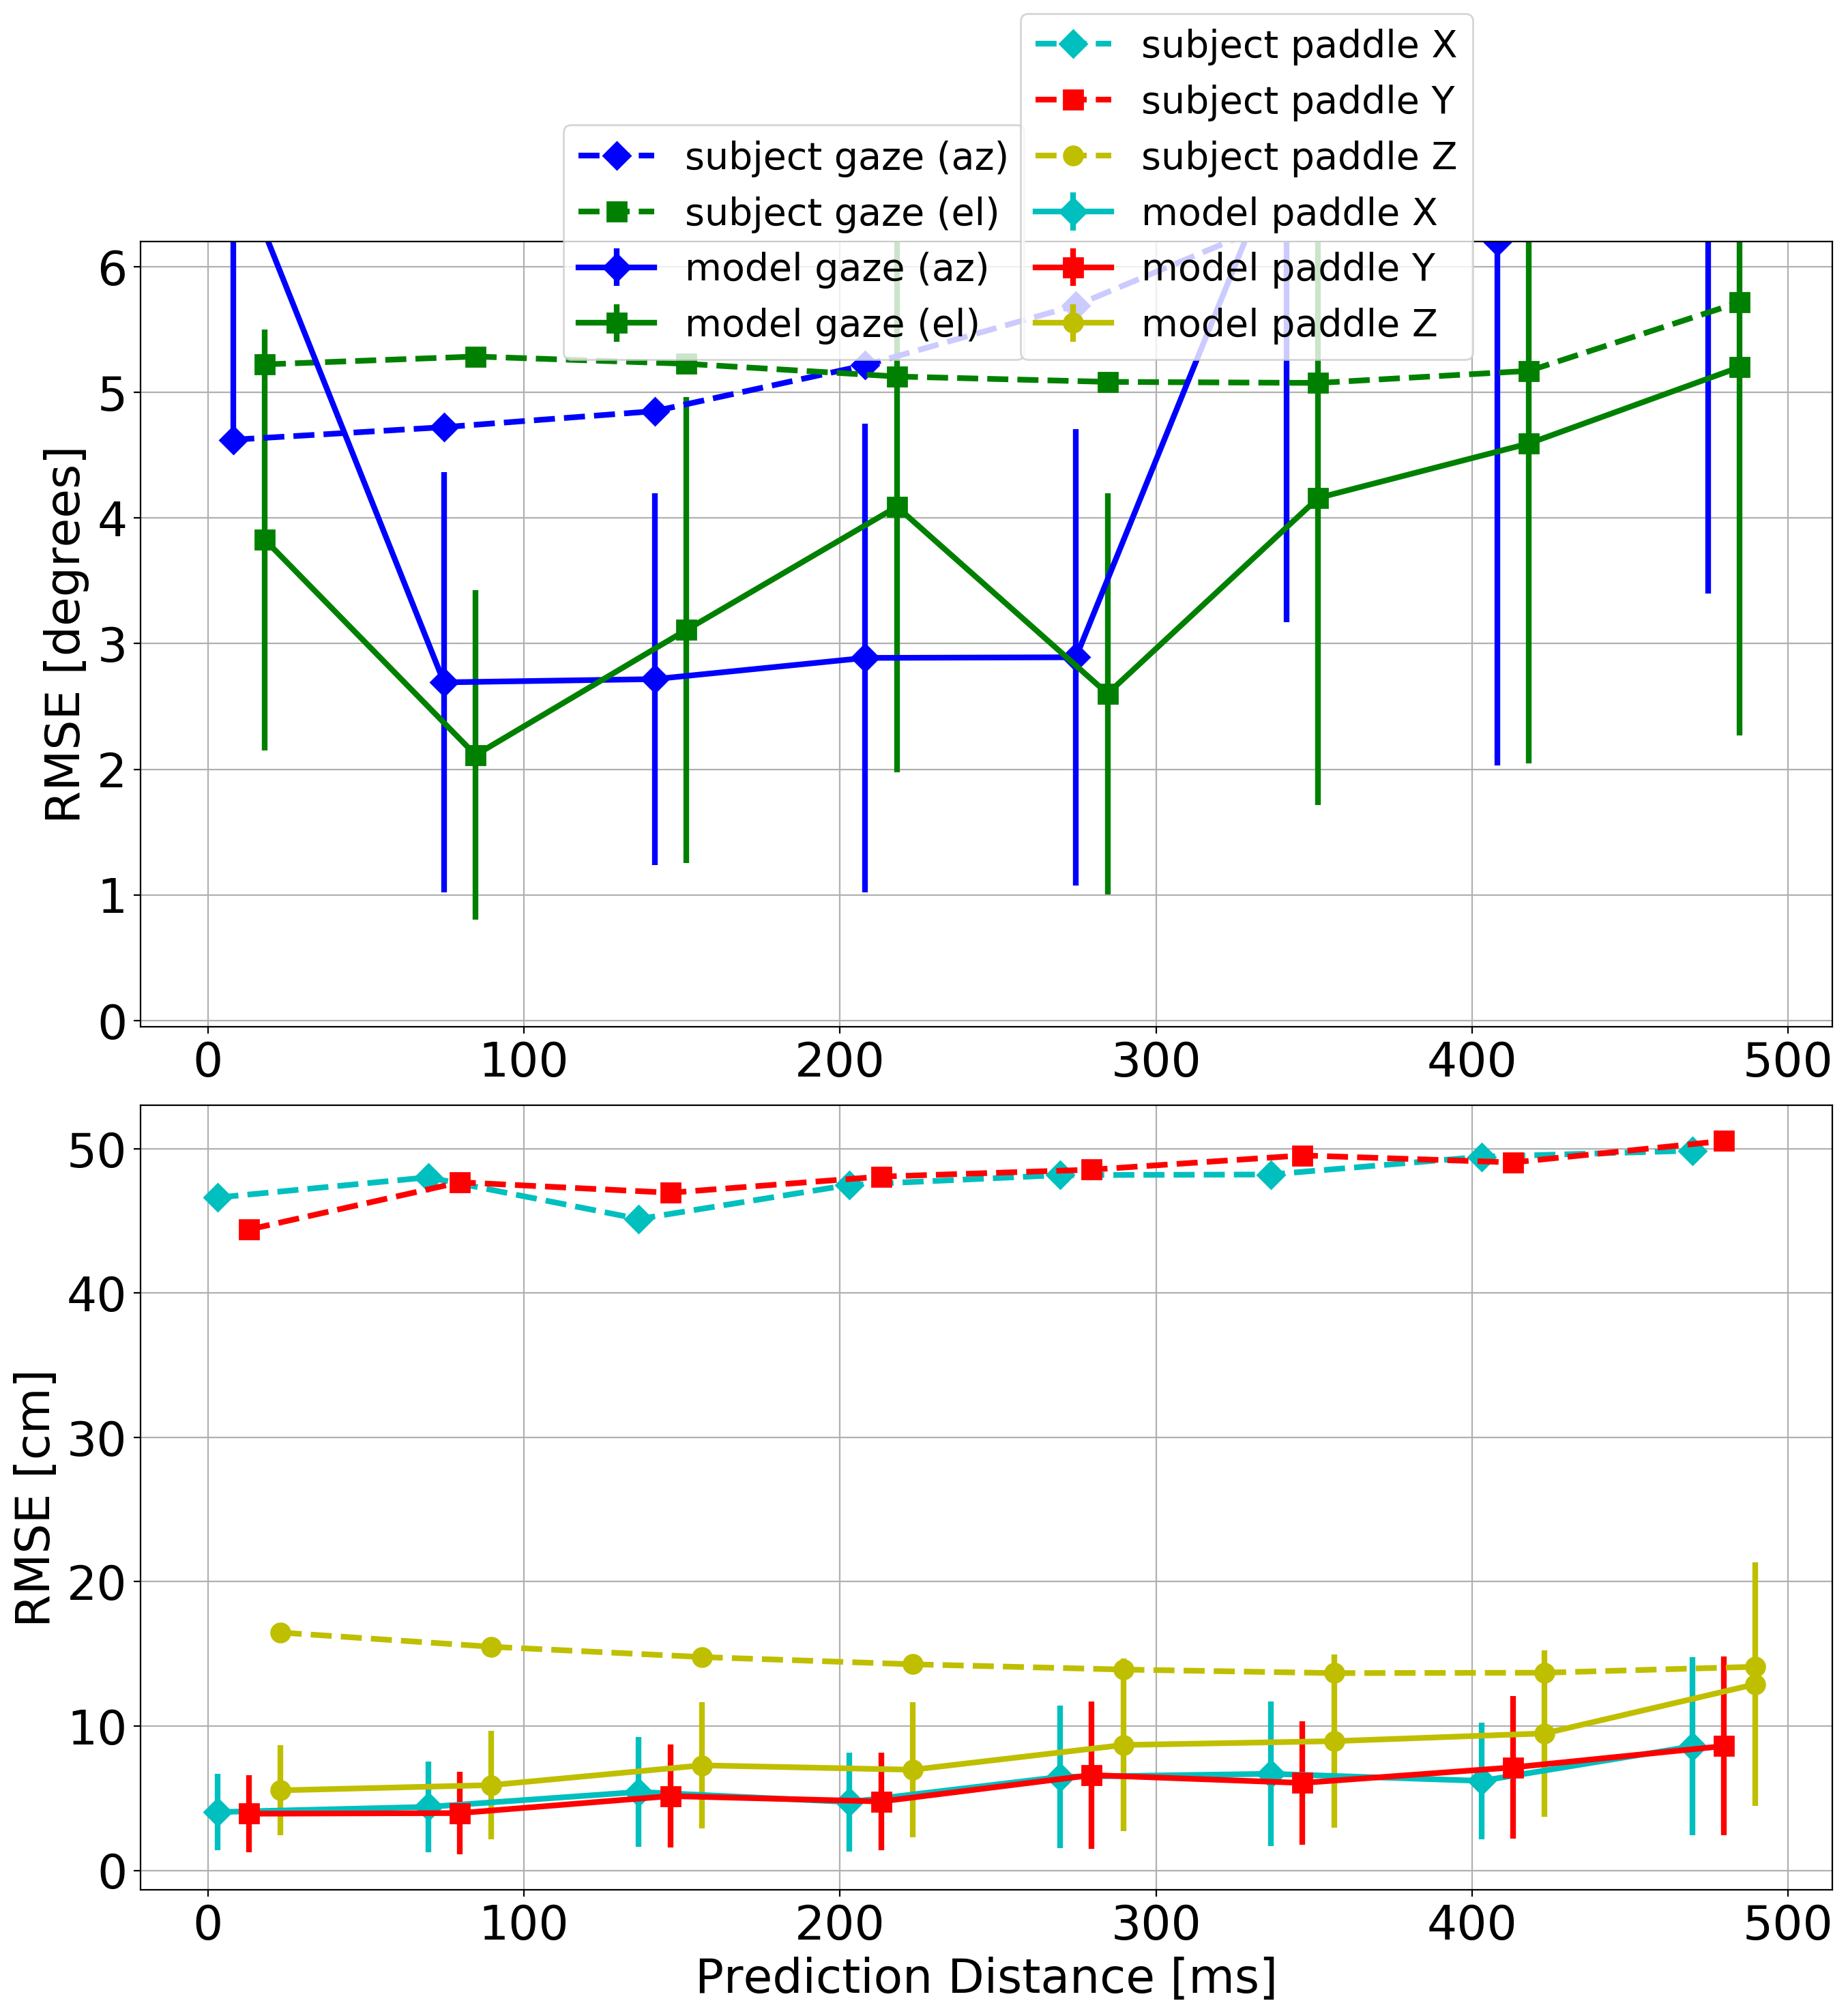

In [14]:
fig = plt.figure(figsize=(16, 16), dpi=200)
fig.subplots_adjust(hspace=0.1)
# Make the y-axis label, ticks and tick labels match the line color.

ax1 = plt.subplot(211)
#fig, ax1 = plt.subplots(figsize=(12, 10), dpi=200)
idx = 0
dSqaured = np.power(TestingResult[:,:,idx]-ModelResult[:,:,idx],2)
plt.errorbar(np.array(timeStepList)*(1000/75)+13-5, np.sqrt(np.mean(dSqaured,axis=1)), yerr = (np.std(np.sqrt(dSqaured),axis=1)), fmt = '-Db', linewidth = 3, markersize = 10, label = 'model gaze (az)')

data = TestingResult[:,:,0]
gazeX = np.std(data, axis = 1)
plt.plot(np.array(timeStepList)*(1000/75)+13-5, gazeX, '--Db', linewidth = 3, markersize = 10, label = 'subject gaze (az)')
#print(gazeX)

idx = 1
dSqaured = np.power(TestingResult[:,:,idx]-ModelResult[:,:,idx],2)
plt.errorbar(np.array(timeStepList)*(1000/75)+13+5, np.sqrt(np.mean(dSqaured,axis=1)), yerr = (np.std(np.sqrt(dSqaured),axis=1)), fmt = '-sg', linewidth = 3, markersize = 10, label = 'model gaze (el)')

data = TestingResult[:,:,1]
gazeY = np.std(data, axis = 1)
plt.plot(np.array(timeStepList)*(1000/75)+13+5, gazeY, '--sg', linewidth = 3, markersize = 10, label = 'subject gaze (el)')
#print(gazeX)

plt.grid(True)
plt.legend(loc = [0.25, 0.85], fontsize = 20)
#plt.title("Gaze Prediction Error\nIntegration Window = 200 ms", fontsize = 20)
#plt.xlabel('Prediction Distance [ms]', fontsize = 25)
plt.ylabel('RMSE [degrees]', fontsize = 25)
plt.ylim(-0.05,6.2)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

ax2 = plt.subplot(212, sharex=ax1)
#plt.setp(ax1.get_xticklabels(), visible=False)

angle = TestingResult[:,:,2]
depth = TestingResult[:,:,4]
x = np.multiply(depth, np.sin(angle))
handX = np.std(x, axis = 1)
#print(handX)

angle = TestingResult[:,:,3]
depth = TestingResult[:,:,4]
y = np.multiply(depth, np.sin(angle))
handY = np.std(y, axis = 1)

data = TestingResult[:,:,4]
handZ = np.std(data, axis = 1)
print(handZ)

idx = 4
myDepth = TestingResult[:,:,idx]-ModelResult[:,:,idx]
idx = 2
angle = TestingResult[:,:,idx]-ModelResult[:,:,idx]
x = np.multiply(myDepth, np.sin(angle))
dSqaured = np.power(x,2)
plt.errorbar(np.array(timeStepList)*(1000/75)+13-10, 100*np.sqrt(np.mean(dSqaured,axis=1)), yerr = 100*(np.std(np.sqrt(dSqaured),axis=1)), fmt = '-Dc', linewidth = 3, markersize = 10, label = 'model paddle X')
plt.plot(np.array(timeStepList)*(1000/75)+13-10, 100*handX, '--Dc', linewidth = 3, markersize = 10, label = 'subject paddle X')
idx = 4
myDepth = TestingResult[:,:,idx]-ModelResult[:,:,idx]
idx = 3
angle = TestingResult[:,:,idx]-ModelResult[:,:,idx]
y = np.multiply(myDepth, np.sin(angle))
dSqaured = np.power(y,2)
plt.errorbar(np.array(timeStepList)*(1000/75)+13, 100*np.sqrt(np.mean(dSqaured,axis=1)), yerr = 100*(np.std(np.sqrt(dSqaured),axis=1)), fmt = '-sr', linewidth = 3, markersize = 10, label = 'model paddle Y')
plt.plot(np.array(timeStepList)*(1000/75)+13, 100*handY, '--sr', linewidth = 3, markersize = 10, label = 'subject paddle Y')


dSqaured = np.power(myDepth,2)
plt.errorbar(np.array(timeStepList)*(1000/75)+13+10, 100*np.sqrt(np.mean(dSqaured,axis=1)), yerr = 100*(np.std(np.sqrt(dSqaured),axis=1)), fmt = '-oy', linewidth = 3, markersize = 10, label = 'model paddle Z')
plt.plot(np.array(timeStepList)*(1000/75)+13+10, 100*handZ, '--oy', linewidth = 3, markersize = 10, label = 'subject paddle Z')

plt.grid(True)
plt.legend(loc = [0.52, 1.95], fontsize = 20)
#plt.title("Hand Prediction Error\nIntegration Window = 200 ms", fontsize = 20)
plt.xlabel('Prediction Distance [ms]', fontsize = 25)
plt.ylabel('RMSE [cm]', fontsize = 25)
#plt.ylim(-0.05,60)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

#plt.savefig('_200_PredictionError_GazeHand_Updated.png', dpi=600)
plt.show()


In [ ]:
plt.figure(figsize=(12, 10), dpi=200)

# Make the y-axis label, ticks and tick labels match the line color.

ax1 = plt.subplot(211)
#fig, ax1 = plt.subplots(figsize=(12, 10), dpi=200)
idx = 0
pgX = np.divide(abs(np.diff(TestingResult[:,:,idx], axis=1)), abs(np.diff(ModelResult[:,:,idx], axis=1)))
dSqaured = np.power(TestingResult[:,:,idx]-ModelResult[:,:,idx],2)
plt.errorbar(np.array(timeStepList)*(1000/75)+13-5, np.sqrt(np.mean(dSqaured,axis=1)), yerr = (np.std(np.sqrt(dSqaured),axis=1)), fmt = '-Db', linewidth = 3, markersize = 10, label = 'Gaze (Azimuth)')
idx = 1
dSqaured = np.power(TestingResult[:,:,idx]-ModelResult[:,:,idx],2)
plt.errorbar(np.array(timeStepList)*(1000/75)+13+5, np.sqrt(np.mean(dSqaured,axis=1)), yerr = (np.std(np.sqrt(dSqaured),axis=1)), fmt = '-sg', linewidth = 3, markersize = 10, label = 'Gaze (Elevation)')

plt.grid(True)
plt.legend(loc = 'upper left', fontsize = 20)
#plt.title("Gaze Prediction Error\nIntegration Window = 200 ms", fontsize = 20)
#plt.xlabel('Prediction Distance [ms]', fontsize = 25)
plt.ylabel('RMSE [degree]', fontsize = 30)
plt.ylim(-0.05,5)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

ax2 = plt.subplot(212, sharex=ax1)
#plt.setp(ax1.get_xticklabels(), visible=False)

idx = 4
myDepth = TestingResult[:,:,idx]-ModelResult[:,:,idx]
idx = 2
angle = TestingResult[:,:,idx]-ModelResult[:,:,idx]
x = np.multiply(myDepth, np.sin(angle))
dSqaured = np.power(x,2)
plt.errorbar(np.array(timeStepList)*(1000/75)+13-10, 100*np.sqrt(np.mean(dSqaured,axis=1)), yerr = 100*(np.std(np.sqrt(dSqaured),axis=1)), fmt = '-Dc', linewidth = 3, markersize = 10, label = 'Paddle (X)')

idx = 4
myDepth = TestingResult[:,:,idx]-ModelResult[:,:,idx]
idx = 3
angle = TestingResult[:,:,idx]-ModelResult[:,:,idx]
y = np.multiply(myDepth, np.sin(angle))
dSqaured = np.power(y,2)
plt.errorbar(np.array(timeStepList)*(1000/75)+13, 100*np.sqrt(np.mean(dSqaured,axis=1)), yerr = 100*(np.std(np.sqrt(dSqaured),axis=1)), fmt = '-sr', linewidth = 3, markersize = 10, label = 'Paddle (Y)')

dSqaured = np.power(myDepth,2)
plt.errorbar(np.array(timeStepList)*(1000/75)+13+10, 100*np.sqrt(np.mean(dSqaured,axis=1)), yerr = 100*(np.std(np.sqrt(dSqaured),axis=1)), fmt = '-oy', linewidth = 3, markersize = 10, label = 'Paddle (Z)')

plt.grid(True)
plt.legend(loc = 'upper left', fontsize = 20)
#plt.title("Hand Prediction Error\nIntegration Window = 200 ms", fontsize = 20)
plt.xlabel('Prediction Distance [ms]', fontsize = 30)
plt.ylabel('RMSE [cm]', fontsize = 30)
#plt.ylim(-0.05,60)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)

plt.savefig('_200_PredictionError_GazeHand.png', dpi=600)
plt.show()


In [ ]:
TestingResult.shape

In [ ]:
print(TestingResult.shape)
print(ModelResult.shape)

plt.figure(figsize=(12, 10), dpi=200)
idx = 2
dSqaured = np.power(TestingResult[:,:,idx]-ModelResult[:,:,idx],2)
plt.errorbar(np.array(timeStepList)*(1000/75)+13, np.sqrt(np.mean(dSqaured,axis=1)), yerr = (np.std(np.sqrt(dSqaured),axis=1)), fmt = '-og', linewidth = 3, label = 'Hand (AZ)')
idx = 3
dSqaured = np.power(TestingResult[:,:,idx]-ModelResult[:,:,idx],2)
plt.errorbar(np.array(timeStepList)*(1000/75)+13+5, np.sqrt(np.mean(dSqaured,axis=1)), yerr = (np.std(np.sqrt(dSqaured),axis=1)), fmt = '-oy', linewidth = 3, label = 'Hand (EL)')

plt.grid(True)
plt.legend(loc = 'upper left', fontsize = 16)
plt.title("Hand Prediction Error\nIntegration Window = 200 ms", fontsize = 20)
plt.xlabel('Prediction Distance [ms]', fontsize = 20)
plt.ylabel('Root Mean Squared Error [Degree]', fontsize = 20)
plt.ylim(-0.05,60)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.savefig('_200_PredictionError_Hand.png', dpi=600)
plt.show()


In [ ]:
print(TestingResult.shape)
print(ModelResult.shape)

plt.figure(figsize=(12, 10), dpi=200)
idx = 5
dSqaured = np.power(TestingResult[:,:,idx]-ModelResult[:,:,idx],2)
plt.errorbar(np.array(timeStepList)*(1000/75)+13 - 5, np.sqrt(np.mean(dSqaured,axis=1)), yerr = (np.std(np.sqrt(dSqaured),axis=1)), fmt = '-ob', linewidth = 3, label = 'Hand Rotation (Roll)')
idx = 6
dSqaured = np.power(TestingResult[:,:,idx]-ModelResult[:,:,idx],2)
plt.errorbar(np.array(timeStepList)*(1000/75)+13, np.sqrt(np.mean(dSqaured,axis=1)), yerr = (np.std(np.sqrt(dSqaured),axis=1)), fmt = '-or', linewidth = 3, label = 'Hand Rotation (Yaw)')
idx = 7
dSqaured = np.power(TestingResult[:,:,idx]-ModelResult[:,:,idx],2)
plt.errorbar(np.array(timeStepList)*(1000/75)+13+5, np.sqrt(np.mean(dSqaured,axis=1)), yerr = (np.std(np.sqrt(dSqaured),axis=1))/5, fmt = '-og', linewidth = 3, label = 'Hand Rotation (Pitch)')


plt.grid(True)
plt.legend(loc = 'upper left', fontsize = 16)
plt.title("Hand Prediction Error\nIntegration Window = 200 ms", fontsize = 20)
plt.xlabel('Prediction Distance [ms]', fontsize = 20)
plt.ylabel('Root Mean Squared Error [Degree]', fontsize = 20)
plt.ylim(-0.05,60)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.savefig('_200_PredictionError_HandRot.png', dpi=600)
plt.show()


In [ ]:
print(TestingResult.shape)
print(ModelResult.shape)

plt.figure(figsize=(12, 10), dpi=200)
idx = 4
dSqaured = np.power(TestingResult[:,:,idx]-ModelResult[:,:,idx],2)
plt.errorbar(np.array(timeStepList)*(1000/75)+13, np.sqrt(np.mean(dSqaured,axis=1)), yerr = (np.std(np.sqrt(dSqaured),axis=1)), fmt = '-ob', linewidth = 3, label = 'Hand (Depth)')


plt.grid(True)
plt.legend()
plt.title("Model Prediction Error\nIntegration Window = 600 ms")
plt.xlabel('Prediction Distance [ms]')
plt.ylabel('Root Mean Squared Error [meters]')
plt.ylim(-0.05,0.4)
plt.savefig('_600_PredictionError_HandDepth.png', dpi=600)
plt.show()


# Subject "2016-4-19-14-4" Results

In [ ]:

data45 = [0.114, 0.095, 0.241, 0.279, 0.285, 0.280, 0.339, 0.402, 0.399, 0.468, 0.483, 0.314, 0.458, 0.308, 0.627, 0.350]
data30 = [0.105, 0.128, 0.198, 0.262, 0.276, 0.251, 0.313, 0.316, 0.329, 0.333, 0.401, 0.324, 0.538, 0.446, 0.586, 0.358]
data15 = [0.279, 0.485, 0.175, 0.228, 0.252, 0.223, 0.313, 0.290, 0.377, 0.419, 0.433, 0.416, 0.460, 0.388, 0.549, 0.385]

plt.figure(figsize=(12, 10), dpi=200)
plt.errorbar(np.array(timeStepList)*(1000/75)+13-5, data15[::2], yerr = np.array(data15[1::2]), fmt = '-or', linewidth = 3, label = 'Integration Window = 200 ms')
plt.errorbar(np.array(timeStepList)*(1000/75)+13, data30[::2], yerr = np.array(data30[1::2]), fmt = '-og', linewidth = 3, label = 'Integration Window = 400 ms')
plt.errorbar(np.array(timeStepList)*(1000/75)+13+5, data45[::2], yerr = np.array(data45[1::2]), fmt = '-ob', linewidth = 3, label = 'Integration Window = 600 ms')


plt.grid(True)
plt.legend()
plt.title("Model Prediction Error")
plt.xlabel('Prediction Distance [ms]')
plt.ylabel('Mean Squared Error')
plt.ylim(0,1.1)
plt.savefig('OneSubject.png', dpi=600)
plt.show()



In [ ]:
# Original Values
#data45 = [0.001, 0.0001, 0.049, 0.094, 0.112, 0.118, 0.130, 0.129, 0.165, 0.111, 0.234, 0.186, 0.271, 0.181, 0.367, 0.242]
#data30 = [0.002, 0.001, 0.049, 0.097, 0.074, 0.095, 0.128, 0.111, 0.217, 0.160, 0.274, 0.208, 0.343,  0.251, 0.409,  0.278]
#data15 = [0.001, 0.001, 0.049, 0.099, 0.077, 0.108, 0.154, 0.137, 0.183, 0.120, 0.284, 0.182, 0.338, 0.251, 0.352, 0.250]

# Changed only Because I need the first value has an std
# Old data45 = [0.001, 0.01, 0.049, 0.094, 0.112, 0.118, 0.130, 0.129, 0.165, 0.111, 0.234, 0.186, 0.271, 0.181, 0.367, 0.242]
# Old data30 = [0.002, 0.01, 0.049, 0.097, 0.074, 0.095, 0.128, 0.111, 0.217, 0.160, 0.274, 0.208, 0.343, 0.251, 0.409, 0.278]
# Old data15 = [0.001, 0.01, 0.049, 0.099, 0.077, 0.108, 0.154, 0.137, 0.183, 0.120, 0.284, 0.182, 0.338, 0.251, 0.352, 0.250]


data45 = [0.001, 0.01, 0.049, 0.083, 0.077, 0.089, 0.130, 0.103, 0.172, 0.117, 0.228, 0.178, 0.257, 0.183, 0.287, 0.208]
data30 = [0.001, 0.01, 0.049, 0.079, 0.090, 0.115, 0.128, 0.102, 0.168, 0.117, 0.231, 0.173, 0.249, 0.178, 0.298, 0.200]
data15 = [0.002, 0.01, 0.044, 0.063, 0.078, 0.091, 0.129, 0.105, 0.161, 0.104, 0.220, 0.186, 0.254, 0.190, 0.286, 0.204]
data8 =  [0.001, 0.01, 0.051, 0.080, 0.078, 0.090, 0.121, 0.082, 0.156, 0.103, 0.216, 0.170, 0.238, 0.190, 0.284, 0.213]
data4 =  [0.002, 0.01, 0.042, 0.061, 0.077, 0.089, 0.113, 0.087, 0.156, 0.102, 0.207, 0.171, 0.238, 0.188, 0.275, 0.202]
data2 =  [0.002, 0.01, 0.043, 0.064, 0.081, 0.091, 0.109, 0.080, 0.153, 0.102, 0.204, 0.161, 0.239, 0.183, 0.280, 0.213]
dataL =  [0.007, 0.015, 0.085, 0.0748, 0.121, 0.099, 0.212, 0.120, 0.253, 0.152, 0.404, 0.261, 0.539, 0.283, 0.60, 0.3]


plt.figure(figsize=(12, 10), dpi=200)
plt.errorbar(np.array(timeStepList)*(1000/75)+13-13, data2[::2], yerr = np.array(data2[1::2]), fmt = '-^c', linewidth = 3, markersize = 10, label = '$I = 27 ms$')
plt.errorbar(np.array(timeStepList)*(1000/75)+13-7, data4[::2], yerr = np.array(data4[1::2]), fmt = '-sr', linewidth = 3, markersize = 10, label = '$I = 53 ms$')
#plt.errorbar(np.array(timeStepList)*(1000/75)+13-5, data8[::2], yerr = np.array(data8[1::2]), fmt = '-.oc', linewidth = 3, label = 'Integration Duration = 106 ms')
plt.errorbar(np.array(timeStepList)*(1000/75)+13, data15[::2], yerr = np.array(data15[1::2]), fmt = '-oy', linewidth = 3, markersize = 10, label = '$I = 200 ms$')
#plt.errorbar(np.array(timeStepList)*(1000/75)+13+5, data30[::2], yerr = np.array(data30[1::2]), fmt = '-.og', linewidth = 3, label = 'Integration Duration = 400 ms')
plt.errorbar(np.array(timeStepList)*(1000/75)+13+7, data45[::2], yerr = np.array(data45[1::2]), fmt = '-vg', linewidth = 3, markersize = 10, label = '$I = 600 ms$')
plt.errorbar(np.array(timeStepList)*(1000/75)+13+13, dataL[::2], yerr = np.array(dataL[1::2]), fmt = '-Dk', linewidth = 3, markersize = 10, label = 'Linear Regression')


plt.grid(True)
plt.legend(loc = 'upper left', fontsize = 20)
#plt.title("Model Prediction Error", fontsize = 20)
plt.xlabel('Prediction Distance [ms]', fontsize = 30)
plt.ylabel('MSE', fontsize = 30)
plt.ylim(-0.02,1)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.savefig('AllSubject.png', dpi=600)
plt.show()


In [ ]:
#(trainTrialInfo + trainTrialInfo[0]).shape
trainTrialInfo[0:3]

In [ ]:
plt.close()

In [ ]:
plt.figure(figsize=(12, 10), dpi=200)
plt.plot(range(modelOutput.shape[0]), modelOutput[:,0],'-ob', label = 'Model Gaze AZ')
#plt.plot(range(modelOutput.shape[0]), modelOutput[:,1],'.b', label = 'Model Gaze EL')
#plt.plot(range(modelOutput.shape[0]), modelOutput[:,2],'^b', label = 'Model Hand AZ')
#plt.plot(range(modelOutput.shape[0]), modelOutput[:,3],'ob', label = 'Model Hand EL')

plt.plot(range(modelOutput.shape[0]), testingOutput[:,0],'-or', label = 'Human Gaze AZ')
#plt.plot(range(modelOutput.shape[0]), testingOutput[:,1],'.r', label = 'Human Gaze EL')
#plt.plot(range(modelOutput.shape[0]), testingOutput[:,2],'^r', label = 'Human Hand AZ')
#plt.plot(range(modelOutput.shape[0]), testingOutput[:,3],'or', label = 'Human Hand EL')

plt.grid(True)
plt.legend()
plt.title("Model Prediction Error")
plt.xlabel('Sample')
plt.ylabel('Angle')
plt.show()


In [ ]:
a = np.arange(170).reshape(17,10)
cnt = 0
seqLength = 6
output = np.zeros((17,seqLength,))
while(seqLength + cnt <= a.shape[1]):
    #print(output)
    #print(a[0:seqLength,:])
    output = np.vstack((output, a[:, 0:seqLength]))
    a = np.roll(a,-1,axis=1)
    cnt = cnt + 1
#output = np.delete(output, 0,0)

output[17:,:].reshape(5,17,6)